# [MY CODE] Last word prediction dataset 준비

In [1]:
import torch
from datasets import load_dataset
from numpy.ma.extras import average
from torch.nn.functional import dropout
from torch.utils.data import DataLoader

ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
  max_len= 400
  texts, labels = [], []
  for row in batch:
    # 라벨을 감정이 아닌 각 텍스트의 뒷자리 단어(토큰) 2개로 변경
    tokenizer_output = tokenizer(row['text'], truncation=True, max_length=max_len)
    labels.append(tokenizer_output.input_ids[-2])
    texts.append(torch.LongTensor(tokenizer_output.input_ids[:-2]))

  # 패딩 처리(길이가 맞지 않는 경우를 위해)
  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

batch_size = 64
train_loader = DataLoader(
    ds['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

/opt/anaconda3/envs/hanghae99_plusAI_2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /Users/kimhongil/.cache/torch/hub/huggingface_pytorch-transformers_main


# [MY CODE] Shape와 입력/출력 확인(빈도 등)

In [133]:
ds['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [134]:
for batch in train_loader:
    inputs, labels = batch  # DataLoader에서 배치 추출
    print(f"입력 텍스트 (input_ids) shape: {inputs.shape}")
    print(f"출력 라벨 (labels) shape: {labels.shape}")
    break  # 첫 번째 배치만 확인

입력 텍스트 (input_ids) shape: torch.Size([64, 398])
출력 라벨 (labels) shape: torch.Size([64])


In [135]:
for batch in train_loader:
    inputs, labels = batch  # DataLoader에서 배치 추출

    # 첫 번째 샘플만 확인
    idx = 0
    first_input = inputs[idx]
    first_label = labels[idx]

    # 입력 텍스트 디코딩 (토큰 단위)
    decoded_tokens = tokenizer.convert_ids_to_tokens(first_input)
    decoded_text = tokenizer.decode(first_input)

    # 라벨 디코딩 (정답 토큰 ID를 텍스트로 변환)
    label_token = tokenizer.convert_ids_to_tokens([first_label])  # 라벨은 단일 토큰
    label_text = tokenizer.decode([first_label])  # 라벨을 문장으로 변환

    # 결과 출력
    print("입력 텍스트 (토큰):", decoded_tokens)
    print("입력 텍스트 (문장):", decoded_text)
    print("출력 라벨 (토큰):", label_token)
    print("출력 라벨 (문장):", label_text)

    break  # 첫 번째 배치만 확인

입력 텍스트 (토큰): ['[CLS]', 'just', 'looking', 'at', 'the', 'sets', ',', 'staging', 'and', 'editing', 'it', 'is', 'easy', 'to', 'tell', 'this', 'project', 'lacked', 'a', 'proper', 'budget', '.', 'maybe', 'bela', 'lu', '##gos', '##i', 'is', 'meant', 'to', 'take', 'your', 'mind', 'off', 'of', 'things', 'like', 'that', '.', 'young', 'bride', '##s', 'drop', 'dead', 'at', 'the', 'altar', 'after', 'saying', '"', 'i', 'do', '"', '.', 'their', 'corpses', 'are', 'stolen', 'by', 'a', 'renowned', 'ho', '##rti', '##cu', '##lt', '##uri', '##st', 'dr', '.', 'loren', '##z', '(', 'lu', '##gos', '##i', ')', 'and', 'a', 'couple', 'of', 'his', 'freak', '##ish', 'minions', 'as', 'his', 'aging', 'wife', '(', 'elizabeth', 'russell', ')', 'needs', 'injection', '##s', 'of', 'the', 'gland', '##ular', 'fluids', 'of', 'the', 'young', 'virgin', '##s', 'to', 'remain', 'forever', 'young', '.', '.', '.', 'forever', 'beautiful', '.', 'an', 'eager', 'local', 'cub', 'reporter', '(', 'lu', '##ana', 'walters', ')', 'realizes'

In [136]:
from collections import Counter

all_labels = []  # 모든 라벨을 저장할 리스트
label_counts = Counter(all_labels)
decoded_labels = tokenizer.convert_ids_to_tokens(list(label_counts.keys()))

# DataLoader에서 배치 순회
for batch in train_loader:
    inputs, labels = batch  # 라벨 추출
    all_labels.extend(labels.tolist())  # 리스트로 변환 후 확장

# 라벨의 유니크 값 확인
unique_labels = set(all_labels)
print("유니크 라벨 목록:", unique_labels)
print(f"총 유니크 라벨 개수: {len(unique_labels)}")


label_counts = Counter(all_labels)
top_10_labels = label_counts.most_common(10)  # 상위 10개 라벨
decoded_top_10 = tokenizer.convert_ids_to_tokens([item[0] for item in top_10_labels])

for word, (token_id, count) in zip(decoded_top_10, top_10_labels):
    print(f"라벨: {word} (토큰 ID: {token_id}) - 등장 횟수: {count}")

유니크 라벨 목록: {8195, 8201, 8212, 8226, 24623, 16437, 8246, 8257, 16451, 8266, 16465, 16467, 24665, 8282, 16481, 8290, 8292, 8307, 24703, 8321, 24714, 24759, 8378, 16571, 8385, 16596, 24795, 24808, 8428, 8429, 8434, 8440, 16636, 8450, 16643, 8472, 8484, 8485, 24871, 8489, 8490, 16681, 16701, 8516, 16709, 8518, 8527, 8529, 8562, 24947, 16755, 8568, 8569, 8572, 24965, 8586, 8589, 8596, 8605, 8607, 8631, 8632, 25020, 16833, 8674, 25066, 16880, 25093, 8713, 16914, 8739, 8740, 8754, 16948, 8785, 8794, 8795, 8797, 8814, 25219, 8836, 8847, 25248, 17075, 8884, 8889, 17083, 8909, 25314, 25325, 8943, 8948, 8954, 17153, 17156, 8973, 9000, 9004, 9009, 9019, 17211, 9027, 25423, 9056, 9061, 17274, 25469, 9092, 17289, 9102, 17298, 9110, 9117, 9120, 17312, 9122, 25508, 9129, 17324, 9143, 9145, 17339, 9148, 25539, 17363, 9179, 999, 1000, 1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 9219, 1028, 1029, 102

In [137]:
from torch import nn
import torch
from torch.optim import Adam, AdamW
import numpy as np
import matplotlib.pyplot as plt
max_len = 400


device = torch.device("mps")

## 주어진 코드

In [138]:
from torch import nn
from math import sqrt

# 셀프 어텐션
class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim # 입력 차원  (보통 어휘 크기((vocab_size)))
    self.d_model = d_model     # 임베딩 차원 (모델 크기에 따라 다르다. BERT는 768..)

    self.wq = nn.Linear(input_dim, d_model)  # 쿼리(입력 -> d_model 차원 변환)
    self.wk = nn.Linear(input_dim, d_model)  #   키(입력 -> d_model 차원 변환)
    self.wv = nn.Linear(input_dim, d_model)  #   값(입력 -> d_model 차원 변환)

    # 최종 출력을 위한 선형 레이어 (d_model -> d_model)
    self.dense = nn.Linear(d_model, d_model)

    # 소프트맥스 (어텐션 가중치 계산을 위해((마지막 차원 기준으로 소프트맥스 수행)))
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    ### 1. Q, K, V 벡터 생성 – 입력을 통해 Wq, Wk, Wv를 선형 변환하여 Q, K, V를 만듬
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
	# Q (Query): 현재 기준이 되는 토큰 (검색 기준)
    # K (Key): 모든 토큰 (기준과 비교할 대상)
    # V (Value): 최종적으로 가중치를 적용해 반환할 값
    # 어텐션 매커니즘은 Q와 K의 유사도를 계산하여 V에서 어떤 정보를 얼마만큼 가져올지 결정한다.



    ### 2. 어텐션 스코어 계산 – 쿼리(Q)와 키(K)를 내적하여 유사도 계산 (Q * K^T)
    # W_q와 W_k는 문맥적으로 유사한 단어를 높은 내적 값을 내뱉도록 학습뇌다.
    # B(Batch Size: 배치 크기), S(Sequence length: 시퀀스 길이), D(Embedding Dimension: 임베딩 차원)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    # 에너지라고도 한다.
    # - 에너지 값이 크면: 쿼리와 키가 매우 유사하다는 의미
    # - 에너지 값이 작을스록 두 벡터간의 상관성이 낮다는 의미

    ### 3. 스코어 정규화 – sqrt(d_model)로 나눠서 스케일링 (값이 너무 크거나 작아지는 문제 방지(vanishing/exploding))
    score = score / sqrt(self.d_model)

    ### 4. 마스킹 – 필요 시 패딩이나 특정 토큰을 제외하기 위해 마스크를 적용
    if mask is not None:
      score = score + (mask * -1e9) # (마스크된 위치(값 1))에 매우 큰 음수 추가 -> 소프트 맥스에서 0이됨)

    ### 5. 소프트맥스를 사용해 어텐션 가중치 계산
    score = self.softmax(score)

	### 6. 어텐션 가중치 적용 – 값 벡터(V)에 어텐션 가중치를 곱해 최종 결과 생성
    # Wv는 유사도가 높은 단어로부터 '올바른 정보'를 가져오도록 학습된다.
    result = torch.matmul(score, v) # 가중치 합이 적용되어 컥텍스트 벡터가 된다.
    # 컨텍스트 벡터는 각 단어(밸류 벡터)에 어텐션 스코어를 곱한 가중합입니다.
    # C_3 = A_<3, 1>V3 + A_<3, 2>V2 + A<3, 3>V3 + A<3, 4>V4


    ### 7. 출력 변환 – 선형 변환(dense)을 통해 최종 출력 생성
    result = self.dense(result)


    return result

In [139]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

In [140]:

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    #preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

# [MY CODE] 마지막 토큰 반환

In [141]:
def get_last_valid_embeddings(x, input_ids, pad_token_id):
    """
    x: (B, S, D) shape (Transformer의 출력 혹은 embedding 결과)
    input_ids: (B, S) shape
    pad_token_id: 정수 (예: 0)

    return: (B, D) shape
    """
    # 1) PAD가 아닌 위치를 True로 표시
    mask = (input_ids != pad_token_id)    # (B, S)  ex) True/False

    # 2) 각 문장(배치)마다 유효 토큰 수
    lengths = mask.sum(dim=1)            # (B, )  ex) [3, 5, 2, ...]

    # 3) 마지막 유효 토큰 인덱스
    last_valid_indices = lengths - 1     # (B, )

    # 4) 인덱싱
    batch_indices = torch.arange(x.size(0))  # (B, ) => [0,1,2,...,B-1]
    last_embeddings = x[batch_indices, last_valid_indices, :]  # (B, D)

    return last_embeddings

In [142]:
def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

# [MY CODE] Loss function 및 classifier output 변경

1. 이진분류 -> 다중 분류
 - loss_fn = nn.CrossEntropyLoss()
 - predict -> 로짓 출력 수정

2. 전체 토큰 수(Vocab Size), 이진 분류가 아니므로 ouput_size를 다양하게 시도
 - 전체 토큰 개수: 일반화에 좋음
 - 라벨 토큰 개수: 태스크가 분명한 경우

3. 어디 토큰을 사용할 것인가?
 - [CLS] : x[:, 0] -> 문장 전체 의미를 요약
 - 평균, 최대 등 등
 - 문장 끝
 - 버트는 cls가 좋다고 하지만... 우리가 요하는건 뒤에만 보면 충분하지않을까?!

4. 추가 전략: 중간 방식
 - 자주 등장하는 라벨(상위 N개)만 output_size로 설정

5. 최적화 기법
 - 드롭아웃
 - 가중치 공유 (난 입력과 출력 사이즈가 다르므로 안씀)

In [143]:
class TextEndPredictor(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, output_size, dropout_rate):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff


    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

    self.dropout_rate = dropout_rate
    self.dropout = nn.Dropout(self.dropout_rate)  # 드롭아웃 레이어 추가

    # 이진 분류가 아니므로 토큰 개수로 변경
    # 라벨 토큰 개수로 바꿔봄
    self.classification = nn.Linear(d_model, output_size)
    #self.classification.weight = self.embedding.weight  # 가중치 공유
    # 써보려했으나 쉐잎이 다름 난 ouput_Size가 라벨임 그러나 임베딩은 vocab

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    input_idx = x
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    for layer in self.layers:
        x = layer(x, mask)


    # 최종 선택
    #x = x[:, 0]
    x = get_last_valid_embeddings(x,  input_idx, pad_token_id=tokenizer.pad_token_id)

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    x = self.classification(x)

    return x

In [144]:
import time

# 라벨 토큰 개수로 바꿔봄
model = TextEndPredictor(len(tokenizer), 32, 2, 32, len(unique_labels), dropout_rate=0)

lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

time_list = []
average_loss_list = []
train_accuracies = []
test_accuracies = []
perplexity_list = []

n_epochs = 50
start_epoch = 0


checkpoint_path = 'checkpoint_TextEndPredictor.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    average_loss_list = checkpoint['average_loss_list']
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    perplexity_list = checkpoint['perplexity_list']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Loss: {average_loss_list[epoch]:.2f} |"
        f" Perplexity: {perplexity_list[epoch]:.2f} |"
        f" Train Acc: {train_accuracies[epoch]:.3f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")

for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).float()

        #preds = model(inputs)[..., 0] # 이진 분류에서 로짓 추출 (기존 손실 함수는 로짓을 원함)
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)

    end_time = time.time()
    epoch_time = end_time - start_time  # 에포크 실행 시간 계산

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        time_list.append(epoch_time)
        average_loss_list.append(average_loss)
        perplexity = torch.exp(torch.tensor(average_loss))  # e^Loss로 퍼플렉서티 계산
        perplexity_list.append(perplexity)

    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'average_loss_list': average_loss_list,
        'perplexity_list':  perplexity_list,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }, checkpoint_path)

    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Loss: {average_loss:.2f} |"
    f" Perplexity: {perplexity:.2f} |"
    f" Train Acc: {train_acc:.3f} |"
    f" Test Acc: {test_acc:.3f}")


Epoch   1 | Time: 32.75 seconds | Loss: 2.15 | Perplexity: 8.63 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   2 | Time: 33.17 seconds | Loss: 1.72 | Perplexity: 5.56 | Train Acc: 0.573 | Test Acc: 0.578
Epoch   3 | Time: 34.56 seconds | Loss: 1.58 | Perplexity: 4.84 | Train Acc: 0.575 | Test Acc: 0.577
Epoch   4 | Time: 32.74 seconds | Loss: 1.51 | Perplexity: 4.54 | Train Acc: 0.581 | Test Acc: 0.582
Epoch   5 | Time: 33.68 seconds | Loss: 1.47 | Perplexity: 4.34 | Train Acc: 0.585 | Test Acc: 0.586
Epoch   6 | Time: 32.85 seconds | Loss: 1.44 | Perplexity: 4.21 | Train Acc: 0.589 | Test Acc: 0.588
Epoch   7 | Time: 32.97 seconds | Loss: 1.39 | Perplexity: 4.03 | Train Acc: 0.591 | Test Acc: 0.590
Epoch   8 | Time: 31.42 seconds | Loss: 1.37 | Perplexity: 3.92 | Train Acc: 0.592 | Test Acc: 0.590
Epoch   9 | Time: 30.82 seconds | Loss: 1.35 | Perplexity: 3.85 | Train Acc: 0.594 | Test Acc: 0.586
Epoch  10 | Time: 32.34 seconds | Loss: 1.33 | Perplexity: 3.78 | Train Acc: 0.594 | Test A

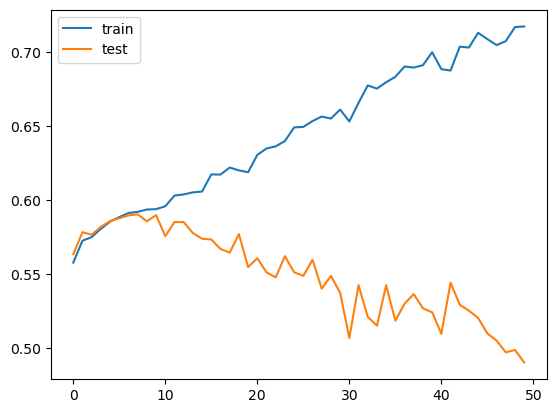

In [145]:
plot_acc(train_accuracies, test_accuracies)

# [MY CODE] 최적화 적용
 - cls로 다시 변경
 - 드롭아웃 (0.3)
 - weight_decay=1e-5
 - 가중치 공유

In [146]:
class TextEndPredictor2(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, output_size, dropout_rate):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff


    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

    self.dropout_rate = dropout_rate
    self.dropout = nn.Dropout(self.dropout_rate)  # 드롭아웃 레이어 추가

    # 이진 분류가 아니므로 토큰 개수로 변경
    # 라벨 토큰 개수로 바꿔봄
    self.classification = nn.Linear(d_model, output_size)
    self.classification.weight = self.embedding.weight  # 가중치 공유
    # 써보려했으나 쉐잎이 다름 난 ouput_Size가 라벨임 그러나 임베딩은 vocab

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    input_idx = x
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    for layer in self.layers:
        x = layer(x, mask)


    # 최종 선택
    x = x[:, 0]
    #x = get_last_valid_embeddings(x,  input_idx, pad_token_id=tokenizer.pad_token_id)

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    x = self.classification(x)

    return x

In [147]:
import time

# 라벨 토큰 개수로 바꿔봄
model = TextEndPredictor2(len(tokenizer), 32, 2, 32, len(tokenizer), dropout_rate=0.3)

lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

time_list = []
average_loss_list = []
train_accuracies = []
test_accuracies = []
perplexity_list = []

n_epochs = 50
start_epoch = 0


checkpoint_path = 'checkpoint_TextEndPredictor2.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    average_loss_list = checkpoint['average_loss_list']
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    perplexity_list = checkpoint['perplexity_list']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Loss: {average_loss_list[epoch]:.2f} |"
        f" Perplexity: {perplexity_list[epoch]:.2f} |"
        f" Train Acc: {train_accuracies[epoch]:.3f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")

for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).float()

        #preds = model(inputs)[..., 0] # 이진 분류에서 로짓 추출 (기존 손실 함수는 로짓을 원함)
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)

    end_time = time.time()
    epoch_time = end_time - start_time  # 에포크 실행 시간 계산

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        time_list.append(epoch_time)
        average_loss_list.append(average_loss)
        perplexity = torch.exp(torch.tensor(average_loss))  # e^Loss로 퍼플렉서티 계산
        perplexity_list.append(perplexity)

    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'average_loss_list': average_loss_list,
        'perplexity_list':  perplexity_list,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }, checkpoint_path)

    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Loss: {average_loss:.2f} |"
    f" Perplexity: {perplexity:.2f} |"
    f" Train Acc: {train_acc:.3f} |"
    f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 35.85 seconds | Loss: 5.78 | Perplexity: 323.56 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   2 | Time: 33.41 seconds | Loss: 4.12 | Perplexity: 61.36 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   3 | Time: 33.90 seconds | Loss: 3.70 | Perplexity: 40.50 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   4 | Time: 37.36 seconds | Loss: 3.53 | Perplexity: 34.11 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   5 | Time: 38.11 seconds | Loss: 3.43 | Perplexity: 31.02 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   6 | Time: 32.94 seconds | Loss: 3.36 | Perplexity: 28.81 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   7 | Time: 32.91 seconds | Loss: 3.31 | Perplexity: 27.37 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   8 | Time: 33.28 seconds | Loss: 3.26 | Perplexity: 25.97 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   9 | Time: 33.17 seconds | Loss: 3.22 | Perplexity: 25.02 | Train Acc: 0.558 | Test Acc: 0.564
Epoch  10 | Time: 33.06 seconds | Loss: 3.19 | Perplexity: 24.18 | Train Acc: 0.5

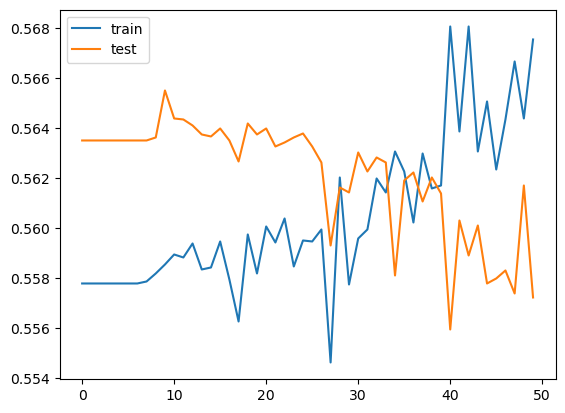

In [148]:
plot_acc(train_accuracies, test_accuracies)

# [MY CODE] 트랜스포머: 잔차 연결 + 레이어 정규화 추가!
  - 셀프 어텐션 횟수 변경(4번)
  - 위치정보 학습

In [153]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x, mask):
    sa_output = self.sa(x, mask)
    x = x + self.dropout(sa_output)
    x = self.norm1(x)

    ffn_output = self.ffn(x)
    x = x + self.dropout(ffn_output)
    x = self.norm2(x)

    return x

In [154]:
class TextEndPredictor3(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, output_size, dropout_rate):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff


    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=True)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

    self.dropout_rate = dropout_rate
    self.dropout = nn.Dropout(self.dropout_rate)  # 드롭아웃 레이어 추가

    # 이진 분류가 아니므로 토큰 개수로 변경
    # 라벨 토큰 개수로 바꿔봄
    self.classification = nn.Linear(d_model, output_size)
    #self.classification.weight = self.embedding.weight  # 가중치 공유
    # 써보려했으나 쉐잎이 다름 난 ouput_Size가 라벨임 그러나 임베딩은 vocab

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    input_idx = x
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    for layer in self.layers:
        x = layer(x, mask)


    # 최종 선택
    #x = x[:, 0]
    x = get_last_valid_embeddings(x,  input_idx, pad_token_id=tokenizer.pad_token_id)

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    x = self.classification(x)

    return x

Epoch   1 | Time: 58.33 seconds | Loss: 2.15 | Perplexity: 8.56 | Train Acc: 0.594 | Test Acc: 0.599
Epoch   2 | Time: 55.31 seconds | Loss: 1.37 | Perplexity: 3.93 | Train Acc: 0.611 | Test Acc: 0.617
Epoch   3 | Time: 54.33 seconds | Loss: 1.21 | Perplexity: 3.35 | Train Acc: 0.618 | Test Acc: 0.621
Epoch   4 | Time: 56.11 seconds | Loss: 1.15 | Perplexity: 3.16 | Train Acc: 0.624 | Test Acc: 0.623
Epoch   5 | Time: 55.82 seconds | Loss: 1.10 | Perplexity: 3.01 | Train Acc: 0.631 | Test Acc: 0.628
Epoch   6 | Time: 56.24 seconds | Loss: 1.06 | Perplexity: 2.89 | Train Acc: 0.637 | Test Acc: 0.625
Epoch   7 | Time: 56.57 seconds | Loss: 1.02 | Perplexity: 2.77 | Train Acc: 0.642 | Test Acc: 0.625
Epoch   8 | Time: 56.24 seconds | Loss: 0.98 | Perplexity: 2.67 | Train Acc: 0.644 | Test Acc: 0.627
Epoch   9 | Time: 55.55 seconds | Loss: 0.95 | Perplexity: 2.58 | Train Acc: 0.658 | Test Acc: 0.617
Epoch  10 | Time: 60.06 seconds | Loss: 0.91 | Perplexity: 2.48 | Train Acc: 0.661 | Test A

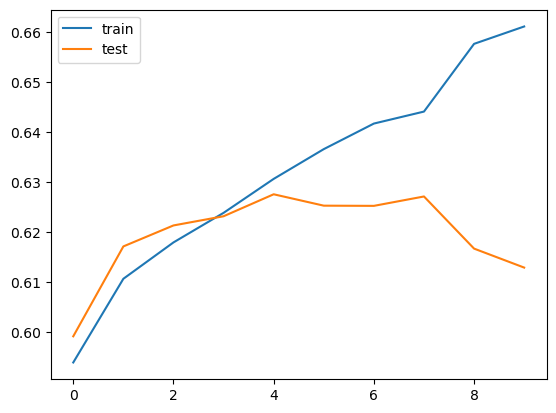

In [156]:
import time

# 라벨 토큰 개수로 바꿔봄
model = TextEndPredictor3(len(tokenizer), 32, 4, 32, len(unique_labels), dropout_rate=0)

lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

time_list = []
average_loss_list = []
train_accuracies = []
test_accuracies = []
perplexity_list = []

n_epochs = 10
start_epoch = 0


checkpoint_path = 'checkpoint_TextEndPredictor3.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    average_loss_list = checkpoint['average_loss_list']
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    perplexity_list = checkpoint['perplexity_list']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Loss: {average_loss_list[epoch]:.2f} |"
        f" Perplexity: {perplexity_list[epoch]:.2f} |"
        f" Train Acc: {train_accuracies[epoch]:.3f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")

for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).float()

        #preds = model(inputs)[..., 0] # 이진 분류에서 로짓 추출 (기존 손실 함수는 로짓을 원함)
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)

    end_time = time.time()
    epoch_time = end_time - start_time  # 에포크 실행 시간 계산

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        time_list.append(epoch_time)
        average_loss_list.append(average_loss)
        perplexity = torch.exp(torch.tensor(average_loss))  # e^Loss로 퍼플렉서티 계산
        perplexity_list.append(perplexity)

    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'average_loss_list': average_loss_list,
        'perplexity_list':  perplexity_list,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }, checkpoint_path)

    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Loss: {average_loss:.2f} |"
    f" Perplexity: {perplexity:.2f} |"
    f" Train Acc: {train_acc:.3f} |"
    f" Test Acc: {test_acc:.3f}")

plot_acc(train_accuracies, test_accuracies)


# [MY CODE] 레이어 2개

In [174]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x, mask):
    sa_output = self.sa(x, mask)
    x = x + self.dropout(sa_output)
    x = self.norm1(x)

    ffn_output = self.ffn(x)
    x = x + self.dropout(ffn_output)
    x = self.norm2(x)

    return x

In [175]:
class TextEndPredictor4(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, output_size):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff


    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])


    self.classification = nn.Linear(d_model, output_size)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    input_idx = x
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
        x = layer(x, mask)


    # 최종 선택
    #x = x[:, 0]
    x = get_last_valid_embeddings(x,  input_idx, pad_token_id=tokenizer.pad_token_id)
    x = self.classification(x)

    return x

새롭게 시작~
Epoch   1 | Time: 36.07 seconds | Loss: 2.27 | Perplexity: 9.68 | Train Acc: 0.595 | Test Acc: 0.600
Epoch   2 | Time: 36.25 seconds | Loss: 1.48 | Perplexity: 4.41 | Train Acc: 0.611 | Test Acc: 0.615
Epoch   3 | Time: 35.07 seconds | Loss: 1.32 | Perplexity: 3.73 | Train Acc: 0.619 | Test Acc: 0.620
Epoch   4 | Time: 35.33 seconds | Loss: 1.22 | Perplexity: 3.39 | Train Acc: 0.622 | Test Acc: 0.621
Epoch   5 | Time: 35.44 seconds | Loss: 1.16 | Perplexity: 3.20 | Train Acc: 0.627 | Test Acc: 0.622
Epoch   6 | Time: 35.22 seconds | Loss: 1.13 | Perplexity: 3.08 | Train Acc: 0.628 | Test Acc: 0.610
Epoch   7 | Time: 35.48 seconds | Loss: 1.09 | Perplexity: 2.96 | Train Acc: 0.636 | Test Acc: 0.613
Epoch   8 | Time: 35.66 seconds | Loss: 1.05 | Perplexity: 2.86 | Train Acc: 0.631 | Test Acc: 0.622
Epoch   9 | Time: 34.96 seconds | Loss: 1.01 | Perplexity: 2.76 | Train Acc: 0.641 | Test Acc: 0.612
Epoch  10 | Time: 35.14 seconds | Loss: 0.98 | Perplexity: 2.67 | Train Acc: 0.645 

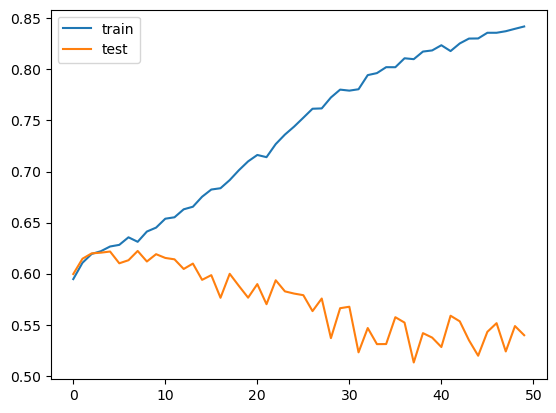

In [176]:
import time
import torch.optim
# 라벨 토큰 개수로 바꿔봄
model = TextEndPredictor4(len(tokenizer), 32, 2, 32, len(unique_labels))

lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

time_list = []
average_loss_list = []
train_accuracies = []
test_accuracies = []
perplexity_list = []

n_epochs = 50
start_epoch = 0


checkpoint_path = 'checkpoint_TextEndPredictor4.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    average_loss_list = checkpoint['average_loss_list']
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    perplexity_list = checkpoint['perplexity_list']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Loss: {average_loss_list[epoch]:.2f} |"
        f" Perplexity: {perplexity_list[epoch]:.2f} |"
        f" Train Acc: {train_accuracies[epoch]:.3f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")

for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).float()

        #preds = model(inputs)[..., 0] # 이진 분류에서 로짓 추출 (기존 손실 함수는 로짓을 원함)
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)

    end_time = time.time()
    epoch_time = end_time - start_time  # 에포크 실행 시간 계산

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        time_list.append(epoch_time)
        average_loss_list.append(average_loss)
        perplexity = torch.exp(torch.tensor(average_loss))  # e^Loss로 퍼플렉서티 계산
        perplexity_list.append(perplexity)

    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'average_loss_list': average_loss_list,
        'perplexity_list':  perplexity_list,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }, checkpoint_path)

    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Loss: {average_loss:.2f} |"
    f" Perplexity: {perplexity:.2f} |"
    f" Train Acc: {train_acc:.3f} |"
    f" Test Acc: {test_acc:.3f}")

plot_acc(train_accuracies, test_accuracies)
